# NYC Green Taxi Report

In [3]:
import warnings
warnings.filterwarnings('ignore')

import os
import urllib
import pandas as pd
import numpy as np
import scipy.stats as stats
import numpy as np
import math 
import folium
from folium import plugins
import geojson
import json
from shapely import geometry
from urllib.request import urlopen
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
import seaborn as sns
%matplotlib inline
sns.set_style("darkgrid")

### Programmatically download and load the data as DataFrame in Pandas.

Please specify the path and filename by yourself if you need to run the code below.

In [2]:
url_green='https://s3.amazonaws.com/nyc-tlc/trip+data/green_tripdata_2015-09.csv'

path='/Files/Projects/CapitalOne_dataset'
#create a local folder to store all the csv file downloaded from website
filename='green_tripdata_2015-09.csv'
#name your file

filepath=os.path.join(path,filename)
#specify the path 
try:
    if not os.path.isfile(filepath):
        urllib.request.urlretrieve(url,filepath)
        print('Successfully downloaded','',filename)
    else:
        print('File is already in local folder.')
except:
    print('Fail to download!')
#Successfully download the data and store all the data in local folder

File is already in local folder.


In [3]:
green=pd.read_csv(filepath)
#load data as pandas DataFrame
print('rows of data:',green.shape[0],'\ncolumns of data:',green.shape[1])

rows of data: 1494926 
columns of data: 21


There are 1494926 rows and 21 columns in total.

In [4]:
green.columns
#print column names

Index(['VendorID', 'lpep_pickup_datetime', 'Lpep_dropoff_datetime',
       'Store_and_fwd_flag', 'RateCodeID', 'Pickup_longitude',
       'Pickup_latitude', 'Dropoff_longitude', 'Dropoff_latitude',
       'Passenger_count', 'Trip_distance', 'Fare_amount', 'Extra', 'MTA_tax',
       'Tip_amount', 'Tolls_amount', 'Ehail_fee', 'improvement_surcharge',
       'Total_amount', 'Payment_type', 'Trip_type '],
      dtype='object')

In [5]:
green.head(10)
#take a glance at the data

,VendorID,lpep_pickup_datetime,Lpep_dropoff_datetime,Store_and_fwd_flag,RateCodeID,Pickup_longitude,Pickup_latitude,Dropoff_longitude,Dropoff_latitude,Passenger_count,...,Fare_amount,Extra,MTA_tax,Tip_amount,Tolls_amount,Ehail_fee,improvement_surcharge,Total_amount,Payment_type,Trip_type
0,2,2015-09-01 00:02:34,2015-09-01 00:02:38,N,5,-73.979485,40.684956,-73.979431,40.685020,1,...,7.8,0.0,0.0,1.95,0.0,NaN,0.0,9.75,1,2.0
1,2,2015-09-01 00:04:20,2015-09-01 00:04:24,N,5,-74.010796,40.912216,-74.010780,40.912212,1,...,45.0,0.0,0.0,0.00,0.0,NaN,0.0,45.00,1,2.0
2,2,2015-09-01 00:01:50,2015-09-01 00:04:24,N,1,-73.921410,40.766708,-73.914413,40.764687,1,...,4.0,0.5,0.5,0.50,0.0,NaN,0.3,5.80,1,1.0
3,2,2015-09-01 00:02:36,2015-09-01 00:06:42,N,1,-73.921387,40.766678,-73.931427,40.771584,1,...,5.0,0.5,0.5,0.00,0.0,NaN,0.3,6.30,2,1.0
4,2,2015-09-01 00:00:14,2015-09-01 00:04:20,N,1,-73.955482,40.714046,-73.944412,40.714729,1,...,5.0,0.5,0.5,0.00,0.0,NaN,0.3,6.30,2,1.0
5,2,2015-09-01 00:00:39,2015-09-01 00:05:20,N,1,-73.945297,40.808186,-73.937668,40.821198,1,...,5.5,0.5,0.5,1.36,0.0,NaN,0.3,8.16,1,1.0
6,2,2015-09-01 00:00:52,2015-09-01 00:05:50,N,1,-73.890877,40.746426,-73.876923,40.756306,1,...,6.5,0.5,0.5,0.00,0.0,NaN,0.3,7.80,1,1.0
7,2,2015-09-01 00:02:15,2015-09-01 00:05:34,N,1,-73.946701,40.797321,-73.937645,40.804516,1,...,5.0,0.5,0.5,0.00,0.0,NaN,0.3,6.30,2,1.0
8,2,2015-09-01 00:02:36,2015-09-01 00:07:20,N,1,-73.963150,40.693829,-73.956787,40.680531,1,...,6.0,0.5,0.5,1.46,0.0,NaN,0.3,8.76,1,1.0
9,2,2015-09-01 00:02:13,2015-09-01 00:07:23,N,1,-73.896820,40.746128,-73.888626,40.752724,1,...,5.5,0.5,0.5,0.00,0.0,NaN,0.3,6.80,2,1.0


In [6]:
#check if there are any missing value
missing_num=green.isnull().sum(axis=0)
missing_percent=(missing_num/(len(green))*100).map(lambda x:'{:0.5f}%'.format(x))
missing=pd.DataFrame(missing_percent,columns=['Missing_percentage'])
missing['Missing_amount']=missing_num
print(missing)

                      Missing_percentage  Missing_amount
VendorID                        0.00000%               0
lpep_pickup_datetime            0.00000%               0
Lpep_dropoff_datetime           0.00000%               0
Store_and_fwd_flag              0.00000%               0
RateCodeID                      0.00000%               0
Pickup_longitude                0.00000%               0
Pickup_latitude                 0.00000%               0
Dropoff_longitude               0.00000%               0
Dropoff_latitude                0.00000%               0
Passenger_count                 0.00000%               0
Trip_distance                   0.00000%               0
Fare_amount                     0.00000%               0
Extra                           0.00000%               0
MTA_tax                         0.00000%               0
Tip_amount                      0.00000%               0
Tolls_amount                    0.00000%               0
Ehail_fee                     1

There is no missing value in Trip_distance.

### Plot the histogram of the number of trip distance.

Text(0.5,1,'With the influence of outliers')

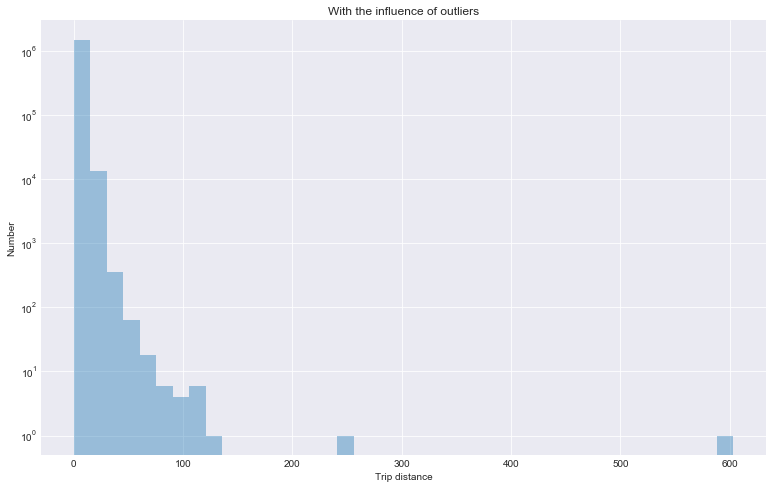

In [7]:
fig=plt.figure(figsize=(13,8))
sns.distplot(green['Trip_distance'],bins=40,kde=False)
plt.yscale('log',nonposy='clip')
#adjust the scale of y axis to show a easy-to-observe histogram
plt.xlabel('Trip distance')
plt.ylabel('Number')
plt.title('With the influence of outliers')

#### Some analysis of the histogram
The distribution of the data is highly skewed. Most of the trip distance values are falling in the range [0,100]. 

In [8]:
green['Trip_distance'].describe()

count    1.494926e+06
mean     2.968141e+00
std      3.076621e+00
min      0.000000e+00
25%      1.100000e+00
50%      1.980000e+00
75%      3.740000e+00
max      6.031000e+02
Name: Trip_distance, dtype: float64

The median is only 1.98.

Firstly, try to perform log transformation on the data to discover underlying distribution.

((array([-4.90374092, -4.72666389, -4.63100617, ...,  4.63100617,
          4.72666389,  4.90374092]),
  array([-4.60517019, -4.60517019, -4.60517019, ...,  4.90305008,
          5.5064691 ,  6.40208302])),
 (0.8972762183007106, 0.7152174382604568, 0.9908774593386882))

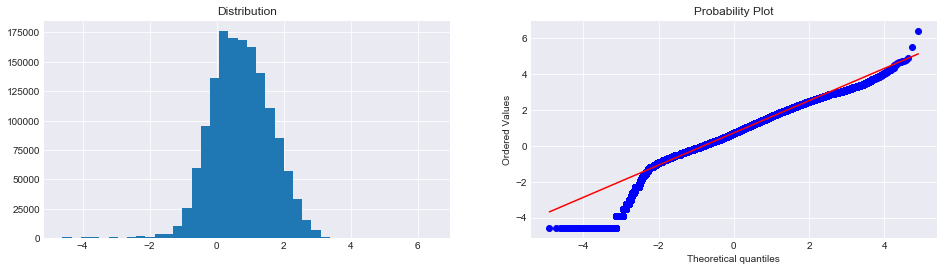

In [9]:
tran_data=np.log(green['Trip_distance'][(green['Trip_distance']>0)])
#draw the qq plot
fig,ax=plt.subplots(1,2,figsize=(16,4))
ax[0].hist(tran_data,bins=40)
ax[0].set_title('Distribution')
stats.probplot(tran_data, dist="norm",plot=ax[1])

From the QQ plot, we can see most of the data fit the straight line very well. 

From histogram, data are almost normally distributed.

I asume there are outliers in the data which distort the picture of data and make the histogram looks in bad shape.

### Try to make the histogram look 'nicer'

Use modified z-score to detect outliers.
If the modified z-score associated with a data point is greater than a threshold, I assume it is a outlier and exclude this point when plotting histogram.

In [10]:
median=np.median(green['Trip_distance'])

In [11]:
MAD=np.median(abs(green['Trip_distance']-median))
m_zscore=0.6745*(green['Trip_distance']-median)/MAD

Use different threshold to plot histogram.

(array([ 67564., 195515., 242649., 180190., 141755., 105990.,  92904.,
         71779.,  61928.,  46586.,  40110.,  32452.,  29202.,  23809.,
         21737.,  18527.,  16761.,  13555.,  11570.,   9064.,   8388.,
          7089.,   6803.,   5844.,   5291.,   4405.,   3952.,   3313.,
          2953.,   2485.,   2340.,   1952.,   1836.,   1637.,   1516.,
          1054.,    972.,    844.,    967.,   1062.]),
 array([ 0.     ,  0.44975,  0.8995 ,  1.34925,  1.799  ,  2.24875,
         2.6985 ,  3.14825,  3.598  ,  4.04775,  4.4975 ,  4.94725,
         5.397  ,  5.84675,  6.2965 ,  6.74625,  7.196  ,  7.64575,
         8.0955 ,  8.54525,  8.995  ,  9.44475,  9.8945 , 10.34425,
        10.794  , 11.24375, 11.6935 , 12.14325, 12.593  , 13.04275,
        13.4925 , 13.94225, 14.392  , 14.84175, 15.2915 , 15.74125,
        16.191  , 16.64075, 17.0905 , 17.54025, 17.99   ]),
 <a list of 40 Patch objects>)

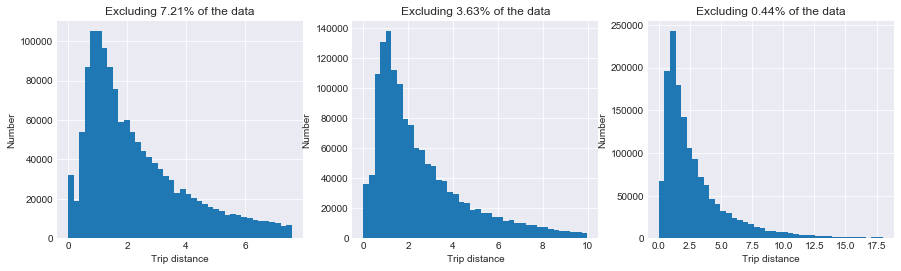

In [12]:
fig,ax=plt.subplots(1,3,figsize=(15,4))
ax[0].set_xlabel('Trip distance')
ax[0].set_ylabel('Number')
ax[0].set_title('Excluding {:0.2f}% of the data'.format((m_zscore>3.5).sum()/len(green)*100))
ax[0].hist(green['Trip_distance'][m_zscore<=3.5],bins=40)
ax[1].set_xlabel('Trip distance')
ax[1].set_ylabel('Number')
ax[1].set_title('Excluding {:0.2f}% of the data'.format((m_zscore>5).sum()/len(green)*100))
ax[1].hist(green['Trip_distance'][m_zscore<=5],bins=40)
ax[2].set_xlabel('Trip distance')
ax[2].set_ylabel('Number')
ax[2].set_title('Excluding {:0.2f}% of the data'.format((m_zscore>10).sum()/len(green)*100))
ax[2].hist(green['Trip_distance'][m_zscore<=10],bins=40)

Modified z-score is more robust than standard z-score. However, using this metric to detect outliers still may encounter problems if the data is highly skewed. In this case, by excluding some 'outliers', I actually get 'nicer' histogram plots helping me to discover the data.

Also, setting the threshold is another thing to worry about (it is usually set to be 3.5). As you can see from the titles of three subplots, I may rule out more data if I make the threshold smaller. 

In this case, I prefer to use a larger threshod since smaller threshold may make wrong detection (as I mentioned, this method still encounters problems when data distribution is highly skewed) and I just intend to get a nicer histogram to better visualize the data distribution.

When ruling out outliers (0.44% of the data), the histogram looks better. 

### Report mean and median trip distance grouped by hour of day.

In [13]:
green['lpep_pickup_datetime']=pd.to_datetime(green['lpep_pickup_datetime'])
green['Lpep_dropoff_datetime']=pd.to_datetime(green['Lpep_dropoff_datetime'])
#make sure the datatype is datetime in python
green['pickup_hour']=green['lpep_pickup_datetime'].map(lambda x:x.hour)
green['dropoff_hour']=green['Lpep_dropoff_datetime'].map(lambda x:x.hour)
#create two new columns

In [14]:
p_exceed1h=((green['dropoff_hour']-green['pickup_hour'])>0).sum()/len(green)*100

print('There are {:0.2f}% of all trips do not complete within the same 1 hour timeslot.'.format(p_exceed1h))

There are 20.66% of all trips do not complete within the same 1 hour timeslot.


There are 20.66% of all trips do not complete within the same 1 hour timeslot. 
(For example: pick up at 00:44:36,and drop off at 01:02:50)

To solve this problem, I may assume the speed of a taxi during a trip remains constant. Then I can just re-calculate the trip distance happened within 1 hour timeslot. 

However, this assumption seems logical but not very pratical. Meanwhile, to simplify this problem, I just consider the Pickup_datetime. 

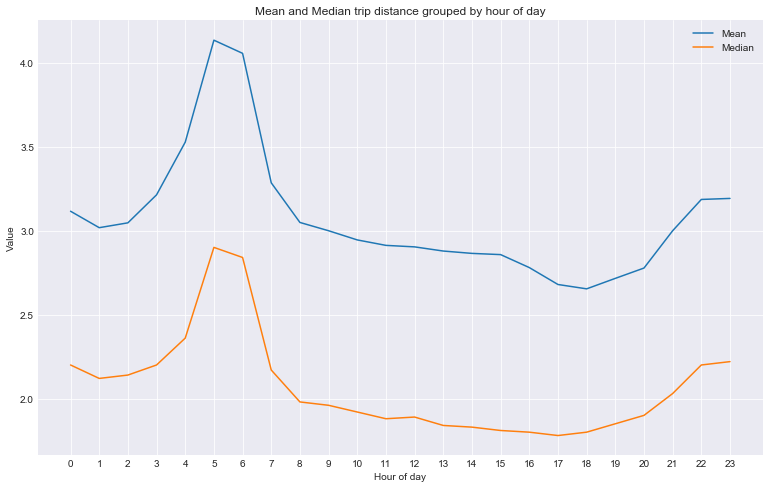

In [15]:
#green['time_delta']=(green['Lpep_dropoff_datetime']-green['lpep_pickup_datetime']).map(lambda x:x.total_seconds())
fig=plt.figure(figsize=(13,8))
plt.xticks(range(24))
plt.title('Mean and Median trip distance grouped by hour of day')
plt.xlabel('Hour of day')
plt.ylabel('Value')
plt.plot(green['pickup_hour'].unique(),green.groupby(by='pickup_hour')['Trip_distance'].mean(),label='Mean')
plt.plot(green['pickup_hour'].unique(),green.groupby(by='pickup_hour')['Trip_distance'].median(),label='Median')
plt.legend(loc='best')

### Trips that originate or terminate at one of the NYC area airports

There is a quick way to identify trips that terminate at one of the NYC area airports (Newark or JFK) by using RateCodeID column.

Here is the description of RateCodeID from data dictionary.

The final rate code in effect at the end of the trip.

1= Standard rate

2=JFK

3=Newark

4=Nassau or Westchester

5=Negotiated fare

6=Group ride

To find trips that terminate at one of the NYC area airports with the information provided, I only need to find all the trips with RateCodeID equals to 2 or 3.

In [16]:
trip_terminate=green[(green['RateCodeID']==2)|(green['RateCodeID']==3)]
num_transaction=len(trip_terminate)
avg_fare=trip_terminate['Fare_amount'].mean()
avg_total_amount=trip_terminate['Total_amount'].mean()

In [17]:
print('There are {} transactions fit this criteria'.format(num_transaction))

There are 5552 transactions fit this criteria


In [18]:
print('The average fare is {}$'.format(avg_fare))

The average fare is 48.976945244956774$


In [19]:
print('The average total amount is {}$'.format(avg_total_amount))

The average total amount is 57.20842038904719$


However, the trips I just found do not contain trips that originate at airports. 

To find these trips, one can use the location information provided by 'Pickup_longitude' and 'Pickup_latitude'.

For NYC area airports, I only consider 3 major airports serving the New York City:

John F. Kennedy International Airport

Newark Liberty International Airport

LaGuardia Airport

Select several points on Google map and get the cooridnates. Then I can turn these points into 3 polygon objects using Shapely in python to roughly represent the 3 airport areas.(One can use more points to form the polygon to represent the area more accurately) What I need to do is just to determine whether a pick up location or a drop off location is in one of the polygons or not(by calling polygon.contains in Shapely).

This method is very time consuming with high computational cost. I prefer not to use it due to time limit. However, I think one can apply this method to give better result without doubt.

In [146]:
lga_pointslist=[[40.773454,-73.888874],[40.767391,-73.887730],[40.771781,-73.873404],[40.766982,-73.863290],[40.772197,-73.855156],[40.781424,-73.875037],[40.779928,-73.884661],[40,774137,-73.883912]]
#LGA
newark_pointslist=[[40.708229,-74.1780298],[40.688120,-74.192501],[40.665364,-74.181957],[40.705659,-74,152184],[40.708451,-74.178360]]
#Newark airport
jfk_pointslist=[[40.664833,-73.829687],[40.649937,-73.825988],[40.625416,-73.769367],[40.639766,-73.743506],[40.665483,-73.795606]]
#JFK

#HERE ARE SOME POINTS I CAPTURE FROM GOOGLE MAP TO DEPICT CONTOUR OF AIRPORT AREAS.

In [147]:
def gen_poly(pointslist):
    points=[]
    for i in pointslist:
        points.append(geometry.Point(i))
    poly=geometry.LineString([p.x,p.y] for p in points)
    return poly

One can use the function I define here to create a polygon given some of the points on the contour (of 3 airports captured) from google map.

In [151]:
airport_trip=green[(green['RateCodeID']==2)|(green['RateCodeID']==3)]
no_airport_trip=green[(green['RateCodeID']!=2)&(green['RateCodeID']!=3)]

In [152]:
green.columns

Index(['VendorID', 'lpep_pickup_datetime', 'Lpep_dropoff_datetime',
       'Store_and_fwd_flag', 'RateCodeID', 'Pickup_longitude',
       'Pickup_latitude', 'Dropoff_longitude', 'Dropoff_latitude',
       'Passenger_count', 'Trip_distance', 'Fare_amount', 'Extra', 'MTA_tax',
       'Tip_amount', 'Tolls_amount', 'Ehail_fee', 'improvement_surcharge',
       'Total_amount', 'Payment_type', 'Trip_type ', 'pickup_hour',
       'dropoff_hour', 'Tip_percentage'],
      dtype='object')

Let us take a look at the time (hour in a day) when different kinds of trip (airport trip and no airport trip) happened.

In [1533]:
airport_triptime=airport_trip.groupby('pickup_hour')['VendorID'].count()
no_airport_triptime=no_airport_trip.groupby('pickup_hour')['VendorID'].count()

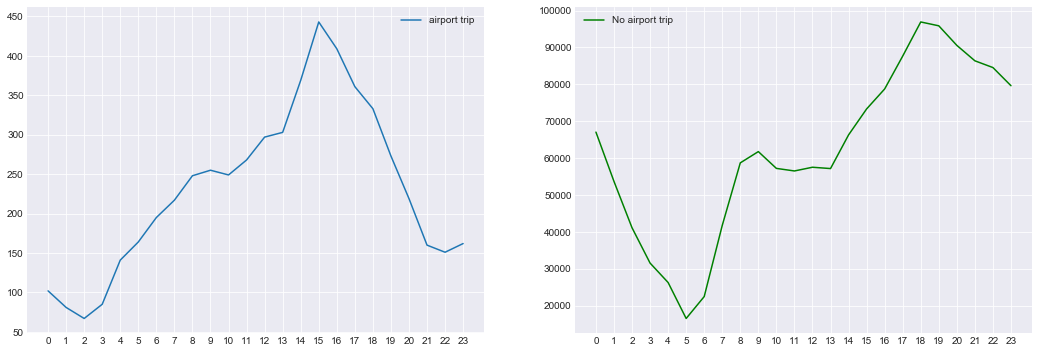

In [1556]:
fig,ax=plt.subplots(1,2,figsize=(18,6))
ax[0].plot(airport_triptime.index,airport_triptime.values,label='airport trip')
ax[0].legend()
ax[0].set_xticks([i for i in range(24)])[0]
ax[1].plot(no_airport_triptime.index,no_airport_triptime.values,label='No airport trip',color='green')
ax[1].legend()
ax[1].set_xticks([i for i in range(24)])[0]

We can see from the plot, trips go to airports do not happend a lot when compared with no-airport trips. 

Also trips go to airports start increaing from 2 AM and reach to a peak around 3 PM. For non-airport trips, the number starts increasing from 5 AM and reach to a peak around 6 PM.

Then, try to dig out more information from Trip_distance and Tip_amount.

In [157]:
airport_trip['Trip_distance'].mean()

10.378195244956757

In [1566]:
no_airport_trip['Trip_distance'].mean()

2.940518090150592

Text(0.5,1,'Trip distance of airport and non-airport trips')

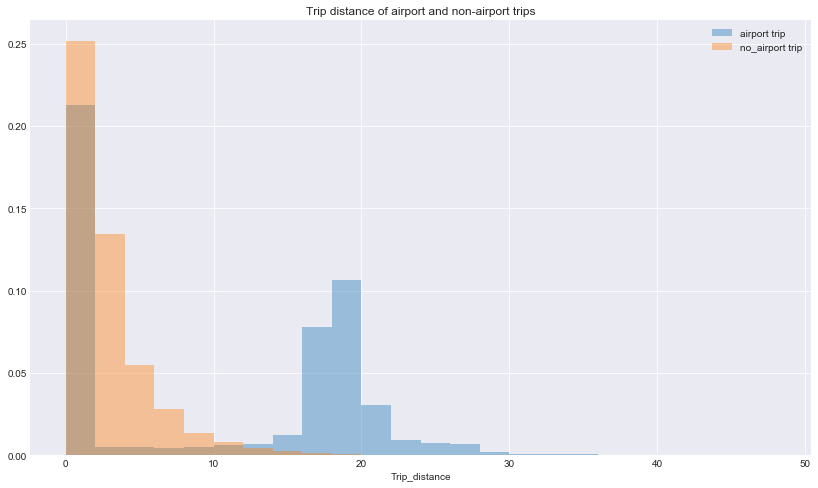

In [1606]:
fig,ax=plt.subplots(figsize=(14,8))
sns.distplot(airport_trip['Trip_distance'],bins=range(0,50,2),kde=False,ax=ax,norm_hist=True,label='airport trip')
sns.distplot(no_airport_trip['Trip_distance'],bins=range(0,50,2),kde=False,ax=ax,norm_hist=True,label='no_airport trip')
plt.legend()
plt.title('Trip distance of airport and non-airport trips')

The distance of trips go to airport tend to be longer than that of non-airport trips.

In [162]:
airport_trip['Tip_amount'].mean()

4.353515850144067

In [163]:
no_airport_trip['Tip_amount'].mean()

1.2241043955382778

Text(0.5,1,'Tip amount of airport and non-airport trips')

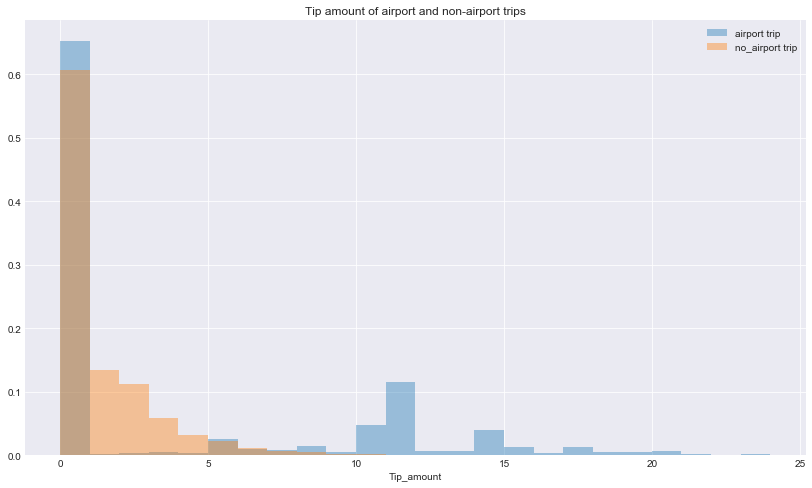

In [1605]:
fig,ax=plt.subplots(figsize=(14,8))
sns.distplot(airport_trip['Tip_amount'],bins=range(0,25,1),kde=False,ax=ax,norm_hist=True,label='airport trip')
sns.distplot(no_airport_trip['Tip_amount'],bins=range(0,25,1),kde=False,ax=ax,norm_hist=True,label='no_airport trip')
plt.legend()
plt.title('Tip amount of airport and non-airport trips')

People go to airports tend to give more tips.

## Build a predictive model for tip as a percentage of the total fare 

In [440]:
green=pd.read_csv(filepath)
green['lpep_pickup_datetime']=pd.to_datetime(green['lpep_pickup_datetime'])
green['Lpep_dropoff_datetime']=pd.to_datetime(green['Lpep_dropoff_datetime'])
green['pickup_hour']=green['lpep_pickup_datetime'].map(lambda x:x.hour)
green['dropoff_hour']=green['Lpep_dropoff_datetime'].map(lambda x:x.hour)

### Data cleaning 

In [441]:
len(green[green['Total_amount']<0])

2417

There are some records with negative total amount. We cannot remove them easily, I would replace these values with their absolute values.

In [442]:
green['Total_amount']=green['Total_amount'].map(lambda x:abs(x))

Do the same thing to 'Fare_amount', 'Extra', 'MTA_tax', 'Tip_amount', 'Tolls_amount', 'Ehail_fee', 'improvement_surcharge'

In [443]:
col_name=['Fare_amount', 'Extra', 'MTA_tax', 'Tip_amount', 'Tolls_amount', 'improvement_surcharge']
for i in col_name:
    green[i]=green[i].map(lambda x:abs(x))

Remove all the trip records with Total_amount is  less than 2.50. It is meaningless to analyze these records according to the fact that Metered Rate of Fare is $2.50 upon entry.

In [444]:
green=green[green['Total_amount']>2.5]

#### Build a derived variable for tip as a percentage of the total fare.

In [445]:
green['Tip_percentage']=green['Tip_amount']/green['Total_amount']*100

### Missing values 

In [446]:
missing_num=green.isnull().sum(axis=0)
missing_percent=(missing_num/(len(green))*100).map(lambda x:'{:0.5f}%'.format(x))
missing=pd.DataFrame(missing_percent,columns=['Missing_percentage'])
missing['Missing_amount']=missing_num
print(missing)

                      Missing_percentage  Missing_amount
VendorID                        0.00000%               0
lpep_pickup_datetime            0.00000%               0
Lpep_dropoff_datetime           0.00000%               0
Store_and_fwd_flag              0.00000%               0
RateCodeID                      0.00000%               0
Pickup_longitude                0.00000%               0
Pickup_latitude                 0.00000%               0
Dropoff_longitude               0.00000%               0
Dropoff_latitude                0.00000%               0
Passenger_count                 0.00000%               0
Trip_distance                   0.00000%               0
Fare_amount                     0.00000%               0
Extra                           0.00000%               0
MTA_tax                         0.00000%               0
Tip_amount                      0.00000%               0
Tolls_amount                    0.00000%               0
Ehail_fee                     1

I drop the Ehail_fee column and fill missing values in Trip_type column with mode.

In [447]:
if 'Ehail_fee' in green.columns:
     green=green.drop('Ehail_fee',axis=1)
#drop the Ehail_fee column
green['Trip_type ']=green['Trip_type '].fillna(green['Trip_type '].mode()[0])
#fill missing values in Trip_type column with mode

### Invalid values

##### Check Passengers count

In [448]:
green['Passenger_count'].unique()

array([1, 2, 5, 6, 4, 3, 8, 0, 9, 7])

In [449]:
pc=green.groupby(['Passenger_count']).count()['VendorID']

Text(0,0.5,'count of records')

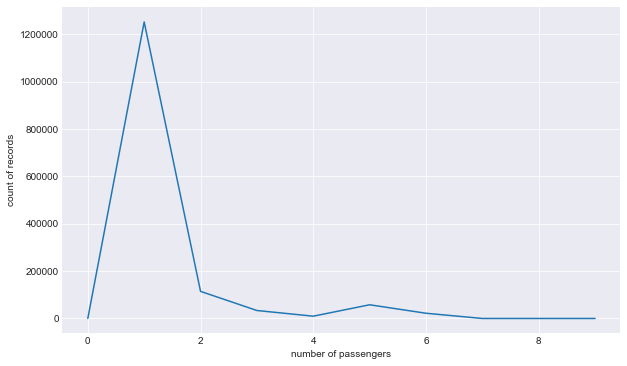

In [450]:
plt.figure(figsize=(10,6))
plt.plot(pc.index,pc.values)
plt.xlabel('number of passengers')
plt.ylabel('count of records')

In [451]:
tip_pc=green.groupby(['Passenger_count'])['Tip_amount'].mean()

Text(0,0.5,'average of tip percentage')

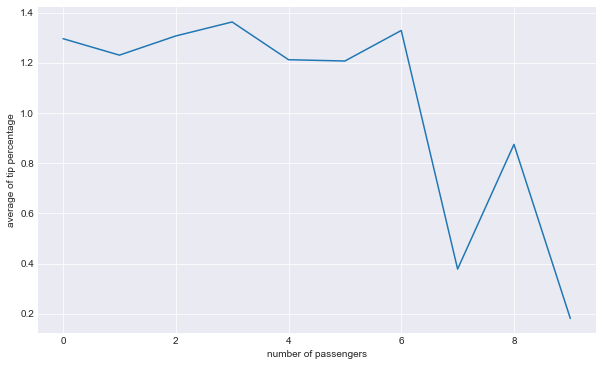

In [452]:
plt.figure(figsize=(10,6))
plt.plot(tip_pc.index,tip_pc.values)
plt.xlabel('number of passengers')
plt.ylabel('average of tip percentage')

It is quite strange to see that there are few trip records where the number of passenger is 0,7,8,9. Since the number of passengers in the vehicle is a driver-entered value, I assume these are becasue drivers did not enter the number correctly. For now I do nothing with these records.

#### Check RateCodeID

In [453]:
green['RateCodeID'].unique()

array([ 5,  1,  2,  4,  3,  6, 99])

99 is a invaild value in this column. I replace 99 with the most common value in 'RateCodeID'.

In [454]:
print('{:0.8f}% RateCodeID values are invalid'.format((green['RateCodeID']==99).sum()/len(green)*100))

0.00026843% RateCodeID values are invalid


In [455]:
mode=green['RateCodeID'].mode()[0]
print('Replace 99 with',mode)

Replace 99 with 1


In [1557]:
green['RateCodeID']=green['RateCodeID'].replace(99,mode)
print('There are {} records with invalid RateCodeID values after processing'.format((green['RateCodeID']==99).sum()))

There are 0 records with invalid RateCodeID values after processing


#### Check Store_and_fwd_flag

In [479]:
green['Store_and_fwd_flag'].unique()
print('There is no valid value in Store_and_fwd_flag column')

There is no valid value in Store_and_fwd_flag column


#### Check Payment_type

In [480]:
green['Payment_type'].unique()
print('There is no valid value in Payment_type column')

There is no valid value in Payment_type column


##### Check Trip_type

In [481]:
green['Trip_type '].unique()
print('There is no valid value in Trip_type column')

There is no valid value in Trip_type column


#### Check VendorID

In [482]:
green['VendorID'].unique()
print('There is no valid value in VendorID column')

There is no valid value in VendorID column


#### Check Extra

In [461]:
green['Extra'].unique()

array([ 0.  ,  0.5 ,  1.  , 12.  ,  0.25,  0.72])

Extra only includes the \$0.50 and \$1 rush hour and overnight charges, so the other values are invalid.

In [462]:
print('There are {} records with invalid Extra values'.format((((green['Extra']!=0.5)&(green['Extra']!=1)&(green['Extra']!=0))).sum()))

There are 3 records with invalid Extra values


Remove these 3 records.

In [1558]:
green=green.drop(green.index[(green['Extra']!=0.5)&(green['Extra']!=1)&(green['Extra']!=0)],axis=0)
print('There are {} records with invalid Extra values after processing'.format((((green['Extra']!=0.5)&(green['Extra']!=1)&(green['Extra']!=0))).sum()))

There are 0 records with invalid Extra values after processing


#### Check Trip_distance

In [420]:
print('There are {} trip records with Trip_distance 0'.format((green['Trip_distance']==0).sum()))

There are 19591 trip records with Trip_distance 0


I may consider to rule out these records when building model later.

### Feature Engineering

In [684]:
mydata=green.copy()

Try to create new features that may help us predict the target value from the information we already know.

In [685]:
'{:0.4f}% of target values are zeros'.format((mydata['Tip_percentage']==0).sum()/len(mydata)*100)

'59.5503% of target values are zeros'

A substantial part of Tip_percentage (around 60%) are 0 values. This would have bad influence if I try to predict the value directly and would make the regression model perform worse.

1.Create a categorical feature to denote whether the tip percentage is 0 or not. 

In [686]:
mydata['Tips']=(green['Tip_percentage']!=0).values+0

2.Create a numerical feature: Hour in a day when the trip started.

3.Create a numerical feature: Hour in a day when the trip ended.

In [687]:
mydata['pickup_hour'].head()

0    0
1    0
2    0
3    0
4    0
Name: pickup_hour, dtype: int64

In [688]:
mydata['dropoff_hour'].head()

0    0
1    0
2    0
3    0
4    0
Name: dropoff_hour, dtype: int64

4.Create a catrgorical feature: The borough where the trip started.

5.Create a catrgorical feature: The borough where the trip ended

In [689]:
def capture(url):
    geo_file=json.loads(str(urlopen(url).read(),'utf-8'))
    return geo_file
url='http://data.beta.nyc//dataset/68c0332f-c3bb-4a78-a0c1-32af515892d6/resource/7c164faa-4458-4ff2-9ef0-09db00b509ef/download/42c737fd496f4d6683bba25fb0e86e1dnycboroughboundaries.geojson'
geo_file=capture(url)

In [691]:
boroughs={}
names=['Bronx','Brooklyn','Manhattan','Queens','Staten Island']
for i in names:
    boroughs[i]=[]
for i in geo_file['features']:
    boro_name=i['properties']['borough']
    boroughs[boro_name].append(geometry.Polygon(i['geometry']['coordinates'][0]))
for i in names:
    boroughs[i]=geometry.MultiPolygon(polygons=boroughs[i])

In [692]:
boroughs

{'Bronx': <shapely.geometry.multipolygon.MultiPolygon at 0x1b19603400>,
 'Brooklyn': <shapely.geometry.multipolygon.MultiPolygon at 0x1b28964e80>,
 'Manhattan': <shapely.geometry.multipolygon.MultiPolygon at 0x1b289643c8>,
 'Queens': <shapely.geometry.multipolygon.MultiPolygon at 0x1a22de42b0>,
 'Staten Island': <shapely.geometry.multipolygon.MultiPolygon at 0x1a1ecdea58>}

In [693]:
def in_polygon(point):
    borough='others'
    for name,area in boroughs.items():
        if area.contains(point):
            borough=name
            break
        else:
            continue
    return borough
#This function can bu used to determine which borough in NYC a given location is in.

In [694]:
green.columns

Index(['VendorID', 'lpep_pickup_datetime', 'Lpep_dropoff_datetime',
       'Store_and_fwd_flag', 'RateCodeID', 'Pickup_longitude',
       'Pickup_latitude', 'Dropoff_longitude', 'Dropoff_latitude',
       'Passenger_count', 'Trip_distance', 'Fare_amount', 'Extra', 'MTA_tax',
       'Tip_amount', 'Tolls_amount', 'improvement_surcharge', 'Total_amount',
       'Payment_type', 'Trip_type ', 'pickup_hour', 'dropoff_hour',
       'Tip_percentage'],
      dtype='object')

In [695]:
mydata['Pickup_loc']=[geometry.Point(i,j) for i,j in zip(green['Pickup_longitude'],green['Pickup_latitude'])]

In [696]:
mydata['Dropoff_loc']=[geometry.Point(i,j) for i,j in zip(green['Dropoff_longitude'],green['Dropoff_latitude'])]

In [697]:
mydata['Pickup_loc']=mydata['Pickup_loc'].map(lambda x:in_polygon(x))

In [707]:
mydata['Dropoff_loc']=mydata['Dropoff_loc'].map(lambda x:in_polygon(x))

This method is very time consuming with high computational cost.

In [709]:
mydata['Pickup_loc'].head()

0    Brooklyn
1      others
2      Queens
3      Queens
4    Brooklyn
Name: Pickup_loc, dtype: object

In [710]:
mydata['Dropoff_loc'].head()

0    Brooklyn
1      others
2      Queens
3      Queens
4    Brooklyn
Name: Dropoff_loc, dtype: object

In [712]:
mydata.to_csv('/Files/Projects/mydata.csv')
#save the data to local as csv file
#I will attach my transformed data in zip file

In [1475]:
# you need to run the commented code if you want to reload the data
#mydata=pd.read_csv('/Files/Projects/mydata.csv')
#mydata['lpep_pickup_datetime']=pd.to_datetime(mydata['lpep_pickup_datetime'])
#mydata['Lpep_dropoff_datetime']=pd.to_datetime(mydata['Lpep_dropoff_datetime'])
#mydata['pickup_hour']=mydata['lpep_pickup_datetime'].map(lambda x:x.hour)
#mydata['dropoff_hour']=mydata['Lpep_dropoff_datetime'].map(lambda x:x.hour)
#mydata=mydata.drop('Unnamed: 0',axis=1)
df=mydata.copy()

It is a reasonable assumption that people may tend to give more tips during weekend or holiday.

To detect whether the trip took place on weekend, record the week day (0-6) when the trip took place. 

Give a value of 7 if that day is holiday. (Sep 7th is Labor Day--Federal Holiday)

6.Create a catergorical feature

In [1476]:
df['weekday or holiday']=df['lpep_pickup_datetime'].map(lambda x:x.date().weekday())
df['weekday or holiday'][df['lpep_pickup_datetime'].map(lambda x:x.day)==7]=7

7.Create a numerical feature: The total time of the trip 

In [1477]:
df['Total_time']=(df['Lpep_dropoff_datetime']-df['lpep_pickup_datetime']).map(lambda x:x.total_seconds())

In [1478]:
df=df.drop(['lpep_pickup_datetime','Tip_amount','Lpep_dropoff_datetime','Pickup_longitude','Pickup_latitude','Dropoff_longitude','Dropoff_latitude'],axis=1)

In [1479]:
df.head()

,VendorID,Store_and_fwd_flag,RateCodeID,Passenger_count,Trip_distance,Fare_amount,Extra,MTA_tax,Tolls_amount,improvement_surcharge,...,Payment_type,Trip_type,pickup_hour,dropoff_hour,Tip_percentage,Tips,Pickup_loc,Dropoff_loc,weekday or holiday,Total_time
0,2,N,5,1,0.00,7.8,0.0,0.0,0.0,0.0,...,1,2.0,0,0,20.00000,1,Brooklyn,Brooklyn,1,4.0
1,2,N,5,1,0.00,45.0,0.0,0.0,0.0,0.0,...,1,2.0,0,0,0.00000,0,others,others,1,4.0
2,2,N,1,1,0.59,4.0,0.5,0.5,0.0,0.3,...,1,1.0,0,0,8.62069,1,Queens,Queens,1,154.0
3,2,N,1,1,0.74,5.0,0.5,0.5,0.0,0.3,...,2,1.0,0,0,0.00000,0,Queens,Queens,1,246.0
4,2,N,1,1,0.61,5.0,0.5,0.5,0.0,0.3,...,2,1.0,0,0,0.00000,0,Brooklyn,Brooklyn,1,246.0


Turn all categorical features into numerical ones.

In [1480]:
df.columns

Index(['VendorID', 'Store_and_fwd_flag', 'RateCodeID', 'Passenger_count',
       'Trip_distance', 'Fare_amount', 'Extra', 'MTA_tax', 'Tolls_amount',
       'improvement_surcharge', 'Total_amount', 'Payment_type', 'Trip_type ',
       'pickup_hour', 'dropoff_hour', 'Tip_percentage', 'Tips', 'Pickup_loc',
       'Dropoff_loc', 'weekday or holiday', 'Total_time'],
      dtype='object')

In [1481]:
target=df[['Tip_percentage', 'Tips']]

Here are the features I identify as categorical ones.

I remove dropoff hour, only keep pickup hour.

In [1482]:
categorical=['Store_and_fwd_flag', 'RateCodeID','Payment_type', 'Trip_type ' ,'Pickup_loc','Dropoff_loc','pickup_hour', 'weekday or holiday']

The other features are numerical ones. 

Text(0.5,1,'Pearson correlation coefficient: 0.3641071955232717')

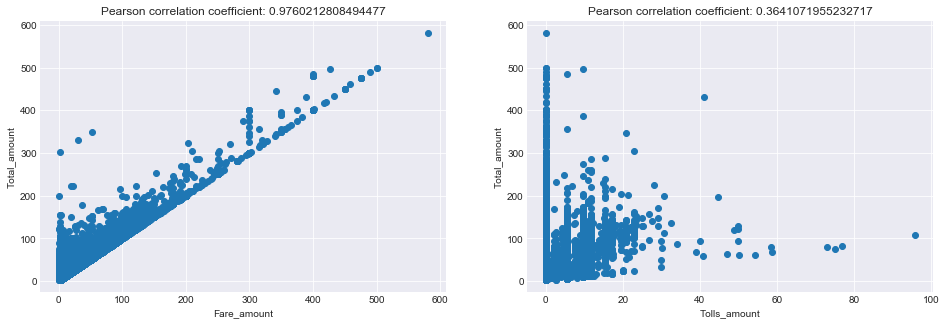

In [1483]:
fig,ax=plt.subplots(1,2,figsize=(16,5))
ax[0].scatter(df['Fare_amount'],df['Total_amount'])
ax[0].set_xlabel('Fare_amount')
ax[0].set_ylabel('Total_amount')
ax[0].set_title('Pearson correlation coefficient: {}'.format(stats.pearsonr(df['Fare_amount'],df['Total_amount'])[0]))

ax[1].scatter(df['Tolls_amount'],df['Total_amount'])
ax[1].set_xlabel('Tolls_amount')
ax[1].set_ylabel('Total_amount')
ax[1].set_title('Pearson correlation coefficient: {}'.format(stats.pearsonr(df['Tolls_amount'],df['Total_amount'])[0]))

It is obvious that total amount is the summation of tips and all other fees. I will need to get rid of Fare_amount. 

Here I will take Extra, improvement_surcharge and MTA_tax as categorical features.

For example, Extra represents rush hour and overnight charges here. I assume whether a trip happened during rush hour or overnight may effect people's behavior regaring how much tips to give. Extra could contain useful information as a categorical feature here

Let's take a look at Fare_amount and Tolls_amount.

As you can see from the plots and results from Pearson correlation test, Fare_amount is hightly correlated to Total_amount.

I will get rid of Fare_amount to eliminate multicollinearity and keep Tolls_amount for the later analysis.

Similarily, go check correlation between each two numerical features.

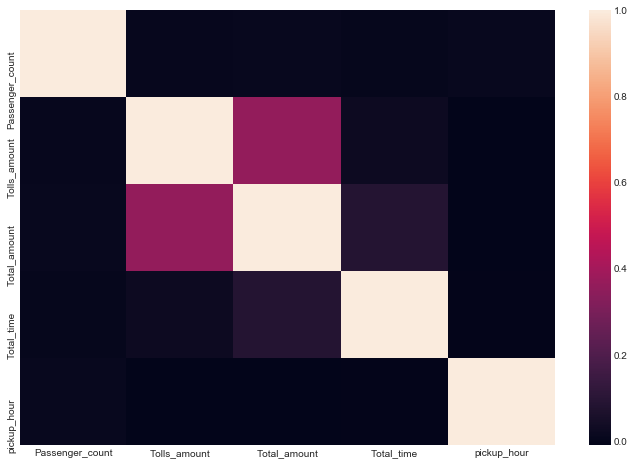

In [1484]:
cor=df[numerical].corr()
plt.figure(figsize=(12,8))
sns.heatmap(cor)

Furthermore, I get rid of Trip distance since it is highly correlated with Total amount.

In [1485]:
numerical=['Passenger_count','Tolls_amount','Total_amount','Total_time']

In [1486]:
categorical.extend(['Extra', 'improvement_surcharge','MTA_tax'])

One can also try chi-square test which I did not do here to check the relation between each numerical feature with target Tip percentage.

#### Apply LabelEncoder and OneHotEncoder to process categorical features.

Create new data to build model.

In [1487]:
modeldata=df.copy()
cate_features=modeldata[categorical]
numerical_features=modeldata[numerical]

In [1488]:
cate_feature=None
for col in categorical:
    LE=LabelEncoder()
    cate_features[col]=LE.fit_transform(df[col]).reshape(len(df),1)
cate_feature=pd.DataFrame(cate_feature)

In [1489]:
cate_features=cate_features.applymap(lambda x:str(x))

In [1490]:
cate_features=pd.get_dummies(cate_features)

In [1491]:
data=pd.concat([cate_features,numerical_features],axis=1)

In [1492]:
data.head()

,Store_and_fwd_flag_0,Store_and_fwd_flag_1,RateCodeID_0,RateCodeID_1,RateCodeID_2,RateCodeID_3,RateCodeID_4,RateCodeID_5,Payment_type_0,Payment_type_1,...,Extra_1,Extra_2,improvement_surcharge_0,improvement_surcharge_1,MTA_tax_0,MTA_tax_1,Passenger_count,Tolls_amount,Total_amount,Total_time
0,1,0,0,0,0,0,1,0,1,0,...,0,0,1,0,1,0,1,0.0,9.75,4.0
1,1,0,0,0,0,0,1,0,1,0,...,0,0,1,0,1,0,1,0.0,45.00,4.0
2,1,0,1,0,0,0,0,0,1,0,...,1,0,0,1,0,1,1,0.0,5.80,154.0
3,1,0,1,0,0,0,0,0,0,1,...,1,0,0,1,0,1,1,0.0,6.30,246.0
4,1,0,1,0,0,0,0,0,0,1,...,1,0,0,1,0,1,1,0.0,6.30,246.0


### Build Model

Here, due to to time limit, I just Use part of the data to build the model and perform test.

One can just use original data by change frac to 1 if he wants to test my model.

In [1505]:
new_data=data.sample(frac=0.4)
new_target=target.iloc[new_data.index,:]

In [1506]:
(new_target['Tips']==0).sum()/len(new_target)

0.5955292941290948

Normalize the numerical features to scale the values make optimization process faster (for example, the convergence of gradient descent).

In [1507]:
trans=StandardScaler().fit(new_data[numerical])

In [1508]:
new_data[numerical]=trans.transform(new_data[numerical])

Create two data for different models. One is used for classification, the other is used for regression.

In [1509]:
data_class=new_data.copy()

In [1510]:
data_regress=new_data.copy()

In [1511]:
data_regress=data_regress[target['Tips']==1]

Perform stratified sampling to make sure I have enough tipped trip and non-tipped trip in my training and test data.

In [1512]:
X_class_train, X_class_test, y_train, y_test= train_test_split(data_class, new_target['Tip_percentage'], test_size = 0.2, stratify=new_target['Tips'])

In [1513]:
X_regress_train=X_class_train[y_train!=0]
y_regress_train=y_train[y_train!=0]
X_regress_test=X_class_test[y_test!=0]
y_regress_test=y_test[y_test!=0]

In [1514]:
y_class_train=new_target['Tips'][y_train.index]
y_class_test=new_target['Tips'][y_test.index]

First, build up a classification model using Logistic Regression with L1 Regularization (namely Lasso Logistic Regression). 

I can keep useful features by tuning the regularization parameter since I just turned my data into high-dimensional by doing one-hot encoding and it is very sparse now.

I do not know how well this model is gonna perform. I can perform really bad if the data is not linealy seperable at all. Let us give it a shot since I assume it tend to be lineary seperable in high-dimensional space. Also, using Logistic Regression is way more efficient when training a large dataset.

In [1515]:
def classification(data,target,params,data_pred):
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2,stratify=target)
    lrcv=LogisticRegressionCV(Cs=params,fit_intercept=True,cv=5,penalty='l1',scoring=None,solver='liblinear', tol=0.0001,max_iter=100,class_weight=None,n_jobs=1,verbose=0,refit=True,multi_class='ovr',random_state=None)
    lrcv.fit(X_train,y_train)
    y_pred_train=lrcv.predict_proba(X_test)
    y_pred_label=lrcv.predict(X_test)
    acc=np.mean(y_pred_label==y_test)
    y_pred_self=lrcv.predict_proba(X_train)
    train_ll=log_loss(y_train,y_pred_self)
    test_ll=log_loss(y_test,y_pred_train)
    prediction=lrcv.predict(data_pred)
#    y_pred_test=clf.predict_proba(data.iloc[train_index:,:])
    return train_ll,test_ll,lrcv.C_,acc,prediction

In [1516]:
_,logloss,_,acc,_=classification(X_class_train,y_class_train,[0.1,0.2,0.4],X_class_test)

In [1517]:
print('The accuracy of the classification model (Logistic Regression) is',acc)
print('The log loss error is',logloss)

The accuracy of the classification model (Logistic Regression) is 0.9355772255426235
The log loss error is 0.1767821022661098


I use classification accuracy and log loss function (cross entropy) to evaluate my binary-classification model.

The performance of logistic model was not bad. However, xgboost actually outperform it without doubt.

However, the cost is higher computaional cost and more hyperparameters to tune.

In [1518]:
def classification2(data,target,data_pred):
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size = 0.2)
    xgb=XGBClassifier()
    parameters = {'objective':['binary:logistic'],
              'learning_rate': [0.05],
              'max_depth': [5,6],  
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [150,200],
              'reg_alpha': [0.2]}
# Here, I did not show all the parameters I tried in gridsearch
    clf = GridSearchCV(xgb, parameters, n_jobs=5, cv=5, scoring='neg_log_loss', refit=True)
    clf.fit(X_train, y_train)
    y_train_pred=clf.predict(X_train)
    acc_train=np.mean(y_train_pred==y_train)
    y_pred = clf.predict(X_test)
    acc_test=np.mean(y_pred==y_test)
    prediction=clf.predict(data_pred)
    
    y_pred_prob=clf.predict_proba(X_test)
    ll=log_loss(y_test,y_pred_prob)
    return acc_train,acc_test,prediction,ll

In [1519]:
_,acc,_,logloss=classification2(X_class_train,y_class_train,X_class_test)

In [1520]:
print('The accuracy of the classification model (XGBoost classifier) is',acc)
print('The log loss error is',logloss)

The accuracy of the classification model (XGBoost classifier) is 0.9618957743525217
The log loss error is 0.10339550114992441


Then, I still stick with XGBoost to build up a regression model. I would try to build up a DNN model in keras if given more time, I assume this DNN model will outperform all other models with enough data input. 

This regression model will help me do the prediction if a certain record is first classified as a non-tip trip by my classification model.

In [1521]:
def regression(data,target,data_pred):
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size = 0.2)
    xgb=XGBRegressor()
    parameters = {'objective':['reg:linear'],
              'learning_rate': [0.05], 
              'max_depth': [5,6],
              'subsample': [0.6],
              'colsample_bytree': [0.7],
              'n_estimators': [150,200],
              'reg_alpha': [0.2]}
# Here, I did not show all the parameters I tried in gridsearch
    clf = GridSearchCV(xgb, parameters, n_jobs=5, cv=5, scoring='r2', refit=True)
    clf.fit(X_train, y_train,eval_metric='rmse')
    y_train_pred=clf.predict(X_train)
    mse_train=np.mean((y_train_pred-y_train)**2)
    y_pred = clf.predict(X_test)
    mse_test=np.mean((y_pred-y_test)**2)
    prediction=clf.predict(data_pred)
    return mse_train,mse_test,prediction

In [1522]:
mse_train,mse_test,p=regression(X_regress_train,y_regress_train,X_regress_test)

In [1523]:
print('The mean squared error of this regression model is',mse_test)

The mean squared error of this regression model is 17.758280447329437


After experiment, the result got from my regression model is not very good.

Try to stack the two model together to build up final model.

In [1524]:
def model(X_train,y_train,X_test,y_test):
    
    _,_,p_class,_ = classification2(X_class_train,y_class_train,X_test)
    
    X_regress=X_test.loc[X_test.index[p_class==1].values,:]
     
    _,_,p_regress = regression(X_regress_train,y_regress_train,X_regress)
    
    p_class[p_class==1]=p_class[p_class==1]*p_regress
    
    p=p_class
    
    mse=np.mean((p-y_test)**2)
    
    return p,mse    

In [1525]:
p,mse=model(X_class_train,y_class_train,X_class_test,y_test)

In [1526]:
print('My prediction is',p)
print('The mean squared error is',mse)

My prediction is [ 0 15 18 ...  0 16 20]
The mean squared error is 14.862873303378306


Actually, the result is not very good. The fact is I am only using a part of the data to do the traning process (due to the limit of my slow computer...), I assume the result could be better if I just use more training data to train the model.

Also, as we can see, the performance of regression model is really bad. To optimize the performance, I can try to extract important features to train the regression model since I did not make a lot of efforts regarding feature selection before. I can also try to identify important features with the help of tree models.

If given more time, I may spend more time on feature engineering. It is really important to engineer as many good featues as possible. 

The quality of data determines how good the result would be. In modeling part, we are just trying to find a method to converge to this 'best' result hidden behind the data.

Also, in this part, I use one hot encoding to transform categorical features which makes the computational cost really high. I may consider to select less features which are important to train the model if it is necessary to take time complexity into account .

Or I could use Dask in Python to perform parallel computation.

## Option B: Visualization of the trip data

In [4]:
url_green='https://s3.amazonaws.com/nyc-tlc/trip+data/green_tripdata_2015-09.csv'

path='/Files/Projects/CapitalOne_dataset'
#create a local folder to store all the csv file downloaded from website
filename='green_tripdata_2015-09.csv'
#name your file

filepath=os.path.join(path,filename)
#specify the path 

green=pd.read_csv(filepath)

In [5]:
def capture(url):
    geo_file=json.loads(str(urlopen(url).read(),'utf-8'))
    return geo_file
#It is a function used to capture geo info from the website

In [6]:
#download geo info of NYC boroughs from the url below
url='http://data.beta.nyc//dataset/68c0332f-c3bb-4a78-a0c1-32af515892d6/resource/7c164faa-4458-4ff2-9ef0-09db00b509ef/download/42c737fd496f4d6683bba25fb0e86e1dnycboroughboundaries.geojson'

In [7]:
geo_file=capture(url)

In [8]:
#create an interavtive map to show trip records
#you can choose how many records you would like to see from the map by change N here
N=100
#Here I only show 100 records
trip_map = folium.Map(location=[40.684956,-73.979485])
trip_map.add_child(folium.GeoJson(geo_file,name='geojson'))

for i,j,m,n in zip(green['Pickup_latitude'][:N],green['Pickup_longitude'][:N],green['Dropoff_latitude'][:N],green['Dropoff_longitude'][:N]):    
    p1=[i,j]
    p2=[m,n]
    folium.Marker(p1,icon=folium.Icon(color='green', 
                                         icon='car'),popup='Pick up location').add_to(trip_map)
    folium.Marker(p2,icon=folium.Icon(color='blue',
                                         icon='car'),popup='Drop off location').add_to(trip_map)
#    arrows = get_arrows(locations=[p1, p2], n_arrows=3)

In [9]:
trip_map
#if the interactive map does not appear correctly
#Please reopen it in terminal by typing 
#'jupyter notebook--NotebookApp.iopub_data_rate_limit=1000000 nlssccd_CC.ipynb'
#And run the code in Option B part again.

This plot shows the location of the trips where green icons represent pickup locations and blue ones represent dropoff location.

In next plot, I would like to take a look at the trip tracks.

In [10]:
N=500
trip_map = folium.Map(location=[40.684956,-73.979485])
trip_map.add_child(folium.GeoJson(geo_file,name='geojson'))

for i,j,m,n in zip(green['Pickup_latitude'][:N],green['Pickup_longitude'][:N],green['Dropoff_latitude'][:N],green['Dropoff_longitude'][:N]):    
    p1=[i,j]
    p2=[m,n]
    folium.PolyLine(locations=[p1, p2], color='red',weight=2, opacity=0.7).add_to(trip_map)
trip_map

This plot shows how the traffic happend in New York city by showing the tracks.

Due to the time limit, I just roughly show the tracks. 

In [11]:
trip_map_pickup = folium.Map(location=[40.684956,-73.979485])
trip_map_pickup.add_child(folium.GeoJson(geo_file,name='geojson'))
hm_pickup=plugins.HeatMap(green[['Pickup_latitude','Pickup_longitude']][:25000].values.tolist(),radius=15)
trip_map_pickup.add_child(hm_pickup)
trip_map_pickup

This heatmap shows where the trips happened mostly. You can zoom in to see more details

I just showed pickup location in this plot. We can obviously see from the map that most trips started from Manhattan, Brooklyn and Queens. People tend to use taxis more in these thress boroughs.

In [1036]:
loc=mydata[['Pickup_loc','Dropoff_loc']]
loc['Trip_count']=1
loc=pd.pivot_table(loc,values='Trip_count',aggfunc='count',index=['Pickup_loc'],columns=['Dropoff_loc'])

In [1050]:
loc=loc.replace(np.nan,0)
loc=loc.applymap(lambda x:int(x))
loc

Dropoff_loc,Bronx,Brooklyn,Manhattan,Queens,Staten Island,others
Pickup_loc,,,,,,
Bronx,61813,443,18220,1548,1,1113
Brooklyn,759,433111,97052,34819,177,1427
Manhattan,37143,3126,369789,13131,15,1654
Queens,2238,20294,36827,350567,34,1809
Staten Island,0,9,3,1,83,1
others,446,579,526,509,0,879


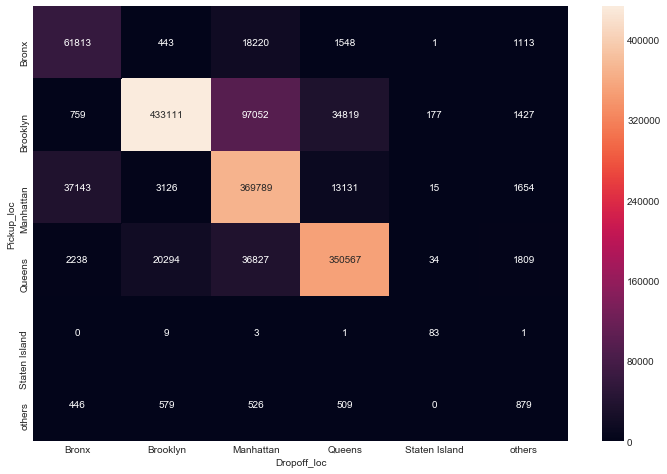

In [1052]:
plt.figure(figsize=(12,8))
sns.heatmap(loc,annot=True,fmt='d')

From the heatmap, we can see how many inter-borough and intra-borough trips happended. 

It is easy to tell that most trips happened within Brooklyn. 

For intra-borough traffic, People who have activities within Brooklyn, Manhattan and Queens prefer to take taxi to commute.

For inter-borough traffic, People who go from Brooklyn to Manhattan or to Queens tend to use green taxi more.

To draw a conclusion, I assume people from Brooklyn are more into green taxi than people from other parts of New York city. It is an interesting fact we can see from the data.